In [3]:
import numpy as np
import graph_structure as gs 
import itertools
from tqdm import tqdm
import time
import pandas as pd
import matplotlib.pyplot as plt

# Comparison between CKA and NN-GS

Topics:
- Resilience to unbalance in datasets
- Flexibility of using different metrics
- Approximate nearest neighbors could improve efficiency

What we already have: 
- Useful in the same cases as CKA

Problem:
- Less resilient to noise in dense neighborhoods

Tasks:
- Make metric a parameter for neighborhood calculation DONE
- Implement CKA as part of the similarity library


Central points on sep-23rd:

CKA is dealing with a macro-structure of elements. It is effective for detecting blobs, but cannot detect if data within blobs was shuffled. This is because the intra-blob distances are smaller than the blob-to-blob distances, which causes the CKA measure to account more for the blob-to-blob distances, overshadowing the intra-blob distances.

NNGS does the opposite, and only considers the intra-blob distances. Thus, moving blobs around has little impact in NNGS, whereas shuffling the items within blobs has a greater impact in NNGS.



$ (X X^T)_{i,j} = \sum_k x_{i,k}x_{j,k} = <x_{i}, x_{j}> = x_{i} x_{j}^T = (X X^T)_{j,i} $


$ (X X^T Y Y^T)_{i,j} = C_{i,j} = \sum_k x_{i} x_{k}^T y_k y_j^T$

 $ = x_{i} (\sum_k x_{k}^T y_k) y_j^T$

$C_{i,i} = x_{i} (\sum_k x_{k}^T y_k) y_i^T$

$tr(C) = \sum_i C_{i,i} = \sum_i x_{i} (\sum_k x_{k}^T y_k) y_i^T$

$tr(C) =\sum_i \sum_k x_{i} x_{k}^T y_k y_i^T$

$(Y^T X)_{i,j} = \sum_k y_{k,i} x_{k,j}$

$||Y^T X||_F^2 = \sum_i \sum_j (\sum_k y_{k,i} x_{k,j})^2$

In [4]:
def create_aligned_dataset(
    n_dim: int,
    n_items: list,
    mu1: list,
    sigma1: list,
    mu2: list,
    sigma2: list,
):
    X1 = []
    X2 = []
    for i in range(len(n_items)):
        x_ = np.random.normal(0, 1, (n_items[i], n_dim))
        x1_ = x_ * sigma1[i] + mu1[i]
        x2_ = x_ * sigma2[i] + mu2[i]
        X1.append(x1_)
        X2.append(x2_)
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    return X1, X2

def create_aligned_dataset_along_circle(n_points,
                                        min_theta,
                                        max_theta,
                                        space_factor):
    t1 = np.linspace(0, 1, n_points)
    t2 = t1 ** space_factor
    t1 = t1 * (max_theta-min_theta) + min_theta
    t2 = t2 * (max_theta-min_theta) + min_theta
    X1 = np.vstack([np.cos(t1), np.sin(t1)]).T
    X2 = np.vstack([np.cos(t2), np.sin(t2)]).T
    return X1, X2

## Resilience to unbalance in datasets

In [5]:
X, Y = create_aligned_dataset(
    n_dim=2,
    n_items=[10, 1000],
    mu1=[-1, 3],
    sigma1=[2, .1],
    mu2=[-1, 3],
    sigma2=[.1, 2],
)
cka_similarity = gs.cka(X, Y)
gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(X.shape[0]*0.2), metric='cosine', n_jobs=-1)
gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(X.shape[0]*0.2), metric='minkowski', n_jobs=-1)
gulp_similarity = gs.gulp(X, Y, lambda_=1e-2)
print(cka_similarity, gs_similarity_cos, gs_similarity_mink, gulp_similarity)

0.1349626353718806 0.5278426687586619 0.9923362882239732 0.8631755696910659


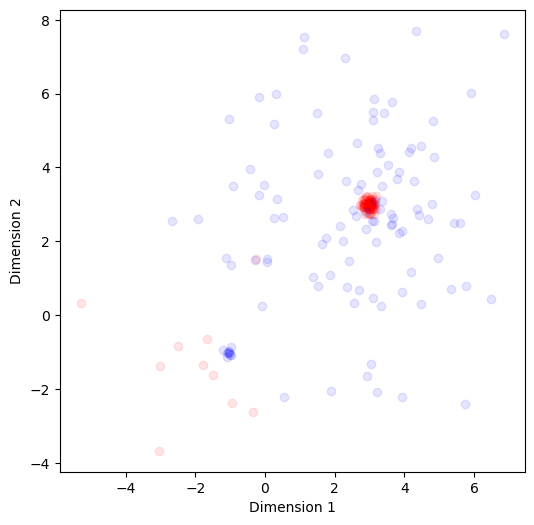

In [107]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.1, c='r', label='X')
plt.scatter(Y[:, 0], Y[:, 1], alpha=0.1, c='b', label='Y')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.title('Scatter plot of X and Y')
plt.show()

# Effective rank is lower



In [6]:
def create_low_rank_dataset(
    n_dim=50,
    temperature=None,
    n_rank=None,
    n_items=[10, 1000],
    mu1=[-1, 3],
    sigma1=[2, .1],
    mu2=[-1, 3],
    sigma2=[.1, 2],):

    def reduce_rank_using_temperature(X, temperature):
        U, s, V = np.linalg.svd(X, full_matrices=False)
        s = np.exp(s / temperature)
        s = s / s[0]
        X = U @ np.diag(s) @ V
        return X

    def reduce_rank_naive(X, rank):
        U, s, V = np.linalg.svd(X, full_matrices=False)
        s[rank:] = 0
        X = U @ np.diag(s) @ V
        return X

    X1 = []
    X2 = []
    for i in range(len(n_items)):
        x_ = np.random.normal(0, 1, (n_items[i], n_dim))
        if n_rank is not None:
            x_ = reduce_rank_naive(x_, n_rank)
        elif temperature is not None:
            x_ = reduce_rank_using_temperature(x_, temperature)
        x1_ = x_ * sigma1[i] + mu1[i]
        x2_ = x_ * sigma2[i] + mu2[i]
        X1.append(x1_)
        X2.append(x2_)
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    return X1, X2

X, Y = create_low_rank_dataset(
    n_dim=2,
    n_rank=2,
    n_items=[10, 100],
    mu1=[-1, 3],
    sigma1=[2, .1],
    mu2=[-1, 3],
    sigma2=[.1, 2],
)

cka_similarity = gs.cka(X, Y)
gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(X.shape[0]*0.2), metric='cosine', n_jobs=-1)
gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(X.shape[0]*0.2), metric='minkowski', n_jobs=-1)
gulp_similarity = gs.gulp(X, Y, lambda_=1e-2)
print(cka_similarity, gs_similarity_cos, gs_similarity_mink, gulp_similarity)

0.37350956298350707 0.5826436870404984 0.9538493033148207 2.310910010864687


In [7]:
def create_low_rank_dataset(
    n_dim=50,
    temperature=None,
    n_rank=None,
    n_items=[10, 1000],
    mu1=[-1, 3],
    sigma1=[2, .1],
    mu2=[-1, 3],
    sigma2=[.1, 2],):

    def reduce_rank_using_temperature(X, temperature):
        U, s, V = np.linalg.svd(X, full_matrices=False)
        s = np.exp(s / temperature)
        s = s / s[0]
        X = U @ np.diag(s) @ V
        return X

    def reduce_rank_naive(X, rank):
        U, s, V = np.linalg.svd(X, full_matrices=False)
        s[rank:] = 0
        X = U @ np.diag(s) @ V
        return X

    X1 = []
    X2 = []
    for i in range(len(n_items)):
        x_ = np.random.normal(0, 1, (n_items[i], n_dim))
        if n_rank is not None:
            x_ = reduce_rank_naive(x_, n_rank)
        elif temperature is not None:
            x_ = reduce_rank_using_temperature(x_, temperature)
        x1_ = x_ * sigma1[i] + mu1[i]
        x2_ = x_ * sigma2[i] + mu2[i]
        X1.append(x1_)
        X2.append(x2_)
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    return X1, X2


In [9]:
X, Y = create_low_rank_dataset(
    n_dim=2,
    n_rank=2,
    n_items=[100],
    mu1=[0],
    sigma1=[1e-1],
    mu2=[0],
    sigma2=[1e-1],
)

X += np.random.normal(0, 1, X.shape)

cka_similarity = gs.cka(X, Y)
gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(X.shape[0]*0.2), metric='cosine', n_jobs=-1)
gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(X.shape[0]*0.2), metric='minkowski', n_jobs=-1)
gulp_similarity = gs.gulp(X, Y, lambda_=1e-2)
print(cka_similarity, gs_similarity_cos, gs_similarity_mink, gulp_similarity)

0.013292909237593662 0.11103638797911232 0.10824437284189595 3.7396929989397707


In [10]:
# Many blobs, noise within blob
# Fixed means, lots of noise
n_dim = 20
n_blobs = [4, 5, 6, 7, 8, 9, 10]
n_items_ = 100
df = pd.DataFrame(
    columns=['n_blob', 'cka', 'gs_cos', 'gs_mink', 'gs_mink_blobs'])
for n_blob in tqdm(n_blobs):
    mu = np.random.randn(n_blob, n_dim) * 30
    sigma = np.ones(n_blob) * 1e-1
    n_items = [100 for _ in range(n_blob)]
    X, Y = create_aligned_dataset(
        n_dim=n_dim,
        n_items=n_items,
        mu1=mu,
        sigma1=sigma,
        mu2=mu,
        sigma2=sigma,
    )

    X += np.random.normal(0, 1, X.shape)
    X -= np.mean(X, axis=0)
    Y -= np.mean(Y, axis=0)

    cka_similarity = gs.cka(X, Y)
    gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(
        X, Y, k=int(n_items_ * 0.2), metric='cosine', n_jobs=-1)
    gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(
        X, Y, k=int(n_items_ * 0.2), metric='minkowski', n_jobs=-1)
    gs_similarity_mink_blobs = gs.mean_neighborhood_similarity_from_points(
        X, Y, k=n_items_ * 3, metric='minkowski', n_jobs=-1)
    gulp_similarity = gs.gulp(X, Y, lambda_=1e-2)
    results = pd.DataFrame({
        'n_blob': [n_blob],
        'cka': [cka_similarity],
        'gs_cos': [gs_similarity_cos],
        'gs_mink': [gs_similarity_mink],
        'gs_mink_blobs': [gs_similarity_mink_blobs],
        'gulp' : [gulp_similarity],
    })
    df = pd.concat([df, results])

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_3563461/1317625941.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, results])
100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


In [11]:
print(df)

  n_blob       cka    gs_cos   gs_mink  gs_mink_blobs      gulp
0      4  0.999805  0.121614  0.122601       0.933011  0.001562
0      5  0.999801  0.116976  0.115067       0.940824  0.001885
0      6  0.999705  0.115047  0.116659       0.956653  0.004020
0      7  0.999746  0.124526  0.122523       0.967580  0.005474
0      8  0.999661  0.113042  0.112742       0.909469  0.007077
0      9  0.999617  0.119094  0.119395       0.924107  0.007834
0     10  0.999627  0.118028  0.116678       0.989549  0.011353


In [12]:
# Many blobs, noise within blob, moving blobs
n_dim=20
n_blobs = [4, 5, 6, 7, 8, 9, 10]
n_items_ = 100
df = pd.DataFrame(columns=['n_blob', 'cka', 'gs_cos', 'gs_mink', 'gulp'])
n_bootstrap = 1
for n_blob in tqdm(n_blobs):
    for n in range(n_bootstrap):
        mux = np.random.randn(n_blob, n_dim) * 30
        muy = np.random.randn(n_blob, n_dim) * 30
        sigma = np.ones(n_blob) * 1e-1
        n_items = [n_items_ for _ in range(n_blob)]
        X, Y = create_low_rank_dataset(
            n_dim=n_dim,
            n_rank=None,
            n_items=n_items,
            mu1=mux,
            sigma1=sigma,
            mu2=muy,
            sigma2=sigma,
        )

        X += np.random.normal(0, 1, X.shape)
        X -= np.mean(X, axis=0)
        Y -= np.mean(Y, axis=0)

        cka_similarity = gs.cka(X, Y)
        gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(n_items_*0.2), metric='cosine', n_jobs=-1)
        gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(X, Y, k=int(n_items_*0.2), metric='minkowski', n_jobs=-1)
        gs_similarity_mink_blobs = gs.mean_neighborhood_similarity_from_points(X, Y, k=n_items_*3, metric='minkowski', n_jobs=-1)
        gulp_similarity = gs.gulp(X, Y, lambda_=1e-2)
        results = pd.DataFrame({
        'n_blob': [n_blob],
        'cka': [cka_similarity],
        'gs_cos': [gs_similarity_cos],
        'gs_mink': [gs_similarity_mink],
        'gs_mink_blobs': [gs_similarity_mink_blobs],
        'gulp' : [gulp_similarity],
        })
        df = pd.concat([df, results])

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_3563461/2980663644.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, results])
100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


In [13]:
print(df)

  n_blob       cka    gs_cos   gs_mink      gulp  gs_mink_blobs
0      4  0.676922  0.115391  0.112261  0.067299       0.503759
0      5  0.937484  0.117811  0.116214  0.043624       0.599400
0      6  0.769216  0.113437  0.115802  0.084721       0.376375
0      7  0.781568  0.116023  0.117006  0.058137       0.419601
0      8  0.772852  0.113261  0.111850  0.103608       0.431228
0      9  0.745853  0.117469  0.115801  0.169125       0.364722
0     10  0.679737  0.114058  0.114569  0.295553       0.339990


CKA only captures similarity in a macro-structure. NNGS captures micro-structures.

In this example, we have an extreme case of low SNR

In [14]:
# Many blobs, there is no noise, but blobs are shuffled
n_dim = 20
n_blobs = [4, 5, 6, 7, 8, 9, 10]
n_items_ = 100
df = pd.DataFrame(
    columns=['n_blob', 'cka', 'gs_cos', 'gs_mink', 'gs_mink_blobs', 'gulp'])
n_bootstrap = 3
for n_blob in tqdm(n_blobs):
    for n in range(n_bootstrap):
        mux = np.random.randn(n_blob, n_dim) * 30
        muy = np.random.randn(n_blob, n_dim) * 30
        sigma = np.ones(n_blob) * 1e-3
        n_items = [n_items_ for _ in range(n_blob)]
        X, Y = create_low_rank_dataset(
            n_dim=n_dim,
            n_rank=None,
            n_items=n_items,
            mu1=mux,
            sigma1=sigma,
            mu2=muy,
            sigma2=sigma,
        )

        #X += np.random.normal(0, 1, X.shape)
        X -= np.mean(X, axis=0)
        Y -= np.mean(Y, axis=0)

        cka_similarity = gs.cka(X, Y)
        gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(
            X, Y, k=int(n_items_ * 0.2), metric='cosine', n_jobs=-1)
        gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(
            X, Y, k=int(n_items_ * 0.2), metric='minkowski', n_jobs=-1)
        gs_similarity_mink_blobs = gs.mean_neighborhood_similarity_from_points(
            X, Y, k=n_items_ * 3, metric='minkowski', n_jobs=-1)
        gulp_similarity = gs.gulp(X, Y, lambda_=1e-2)
        results = pd.DataFrame({
            'n_blob': [n_blob],
            'cka': [cka_similarity],
            'gs_cos': [gs_similarity_cos],
            'gs_mink': [gs_similarity_mink],
            'gs_mink_blobs': [gs_similarity_mink_blobs],
            'gulp' : [gulp_similarity],
        })
        df = pd.concat([df, results])

print(df.groupby('n_blob').agg(['mean', 'std']))


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_3563461/3322190885.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, results])
100%|██████████| 7/7 [00:27<00:00,  3.88s/it]

             cka              gs_cos           gs_mink      gs_mink_blobs  \
            mean       std      mean       std    mean  std          mean   
n_blob                                                                      
4       0.849607  0.153065  0.713405  0.016556     1.0  0.0      0.708311   
5       0.789293  0.023699  0.712600  0.012964     1.0  0.0      0.340534   
6       0.847400  0.017979  0.717519  0.010440     1.0  0.0      0.570647   
7       0.745359  0.081892  0.731860  0.010160     1.0  0.0      0.351467   
8       0.687986  0.030169  0.723905  0.003838     1.0  0.0      0.323555   
9       0.701577  0.041439  0.728810  0.002856     1.0  0.0      0.332593   
10      0.702632  0.061188  0.725313  0.003578     1.0  0.0      0.334890   

                      gulp            
             std      mean       std  
n_blob                                
4       0.187694  0.082285  0.078948  
5       0.090917  0.103892  0.036169  
6       0.010578  0.071661  0.0232

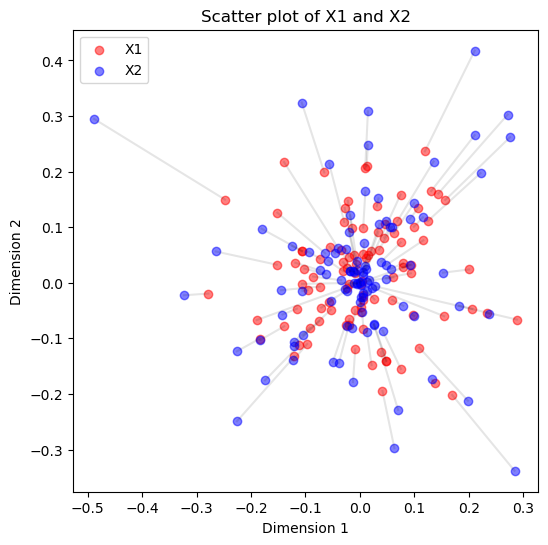

0.7674811454122165 1.0 0.4897310235283743


In [214]:
# Create dataset with blobs but multiply points by random value
def create_aligned_dataset_random_factor(
    n_dim: int,
    n_items: list,
    mu1: list,
    sigma1: list,
    mu2: list,
    sigma2: list,
):
    X1 = []
    X2 = []
    for i in range(len(n_items)):
        x_ = np.random.normal(0, 1, (n_items[i], n_dim))
        x1_ = x_ * sigma1[i] + mu1[i]
        x2_ = x1_ * np.random.uniform(low=0.01, high=2, size=(n_items[i], 1))
        X1.append(x1_)
        X2.append(x2_)
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    return X1, X2

X1, X2 = create_aligned_dataset_random_factor(n_dim=2,
    n_items=[100],
    mu1=[0],
    sigma1=[1e-1],
    mu2=[0],
    sigma2=[1e-1])

plt.figure(figsize=(6, 6))
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.5, c='r', label='X1')
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.5, c='b', label='X2')
for i in range(X1.shape[0]):
    plt.plot([X1[i, 0], X2[i, 0]], [X1[i, 1], X2[i, 1]], 'k-', alpha=0.1)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('Scatter plot of X1 and X2')
plt.show()

cka_similarity = gs.cka(X1, X2)
gs_similarity_cos = gs.mean_neighborhood_similarity_from_points(X1, X2, k=int(n_items_*0.2), metric='cosine', n_jobs=-1)
gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(X1, X2, k=int(n_items_*0.2), metric='minkowski', n_jobs=-1)
print(cka_similarity, gs_similarity_cos, gs_similarity_mink)

In [187]:
X1, X2 = create_aligned_dataset_along_circle(50, 0, np.pi, 1.0)

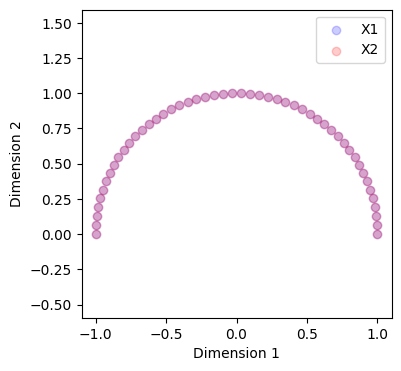

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.2, c='b', label='X1')
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.2, c='r', label='X2')
for i in range(X1.shape[0]):
    plt.plot([X1[i, 0], X2[i, 0]], [X1[i, 1], X2[i, 1]], color='black', alpha=0.2)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.axis('equal')
plt.show()

0.4672655157457886 0.9989769645762784


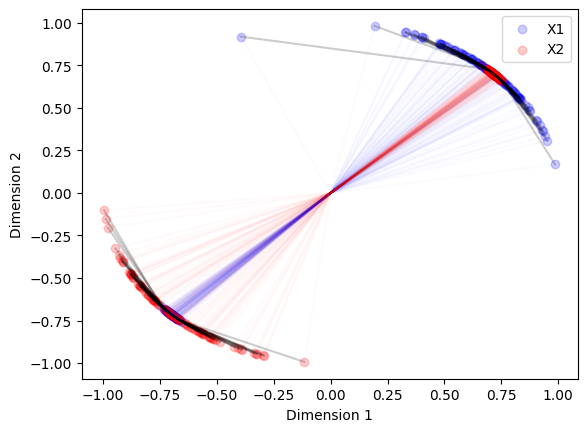

In [7]:
import matplotlib.pyplot as plt

plt.figure()
X1_centered = X1-np.mean(X1, axis=0)
X2_centered = X2-np.mean(X2, axis=0)
X1_centered = X1_centered/np.linalg.norm(X1_centered, axis=1, keepdims=True)
X2_centered = X2_centered/np.linalg.norm(X2_centered, axis=1, keepdims=True)
plt.scatter(X1_centered[:, 0], X1_centered[:, 1], alpha=0.2, c='b', label='X1')
plt.scatter(X2_centered[:, 0], X2_centered[:, 1], alpha=0.2, c='r', label='X2')
for i in range(X1.shape[0]):
    plt.plot([X1_centered[i, 0], X2_centered[i, 0]], [X1_centered[i, 1], X2_centered[i, 1]], color='black', alpha=0.2)

X1_centroid = np.mean(X1, axis=0)
for i in range(X1.shape[0]):
    plt.plot([X1_centered[i, 0], 0], [X1_centered[i, 1], 0], color='b', alpha=0.02)

X2_centroid = np.mean(X2, axis=0)
for i in range(X2.shape[0]):
    plt.plot([X2_centered[i, 0], 0], [X2_centered[i, 1], 0], color='r', alpha=0.02)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

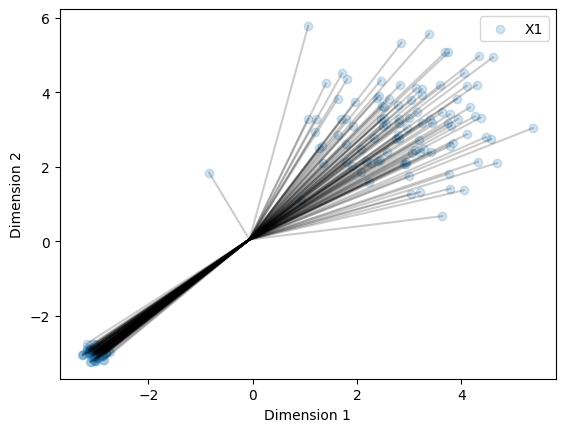

In [8]:
plt.figure()
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.2, label='X1')
X1_centroid = np.mean(X1, axis=0)
for i in range(X1.shape[0]):
    plt.plot([X1[i, 0], X1_centroid[0]], [X1[i, 1], X1_centroid[1]], color='black', alpha=0.2)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [7]:
cka_similarity = cka(X1, X2)
gs_similarity = gs.mean_neighborhood_similarity_from_points(X1, X2, k=3)
print(cka_similarity, gs_similarity)

0.47010087447380805 1.0


In [11]:
nx1 = gs.nearest_neighbors(X1)
nx2 = gs.nearest_neighbors(X2)
for i in range(X1.shape[0]):
    print(f'Ref {i}: X1:{set(nx1[i, 0:3])} \t X2:{set(nx2[i, 0:3])}')

Ref 0: X1:{44, 37, 87} 	 X2:{44, 37, 87}
Ref 1: X1:{96, 66, 86} 	 X2:{96, 66, 86}
Ref 2: X1:{3, 75, 93} 	 X2:{3, 75, 93}
Ref 3: X1:{75, 18, 2} 	 X2:{75, 18, 2}
Ref 4: X1:{25, 36, 6} 	 X2:{25, 36, 6}
Ref 5: X1:{32, 22, 15} 	 X2:{32, 22, 15}
Ref 6: X1:{24, 25, 4} 	 X2:{24, 25, 4}
Ref 7: X1:{42, 70, 55} 	 X2:{42, 70, 55}
Ref 8: X1:{97, 59, 47} 	 X2:{97, 59, 47}
Ref 9: X1:{40, 16, 96} 	 X2:{40, 16, 96}
Ref 10: X1:{50, 83, 84} 	 X2:{50, 83, 84}
Ref 11: X1:{26, 35, 53} 	 X2:{26, 35, 53}
Ref 12: X1:{66, 68, 45} 	 X2:{66, 68, 45}
Ref 13: X1:{49, 17, 95} 	 X2:{49, 17, 95}
Ref 14: X1:{81, 86, 71} 	 X2:{81, 86, 71}
Ref 15: X1:{32, 5, 22} 	 X2:{32, 5, 22}
Ref 16: X1:{42, 77, 70} 	 X2:{42, 77, 70}
Ref 17: X1:{60, 79, 23} 	 X2:{60, 79, 23}
Ref 18: X1:{72, 29, 63} 	 X2:{72, 29, 63}
Ref 19: X1:{41, 68, 12} 	 X2:{41, 68, 12}
Ref 20: X1:{58, 5, 22} 	 X2:{58, 5, 22}
Ref 21: X1:{10, 83, 94} 	 X2:{10, 83, 94}
Ref 22: X1:{85, 5, 15} 	 X2:{85, 5, 15}
Ref 23: X1:{17, 60, 79} 	 X2:{17, 60, 79}
Ref 24: X1:{88, 

In [12]:
factors = np.linspace(1, 10, 100)
list_cka = []
list_gs = []
for factor in factors:
    X1, X2 = create_aligned_dataset_along_circle(10, 0, np.pi, factor)
    cka_similarity = cka(X1, X2)
    gs_similarity = gs.mean_neighborhood_similarity_from_points(X1, X2, k=5)
    list_cka.append(cka_similarity)
    list_gs.append(gs_similarity)

plt.figure()
plt.plot(factors, list_cka, label='CKA')
plt.plot(factors, list_gs, label='GS')
plt.xlabel('Factor')
plt.ylabel('Similarity')
plt.legend()
plt.show()

plt.figure()
xaux = np.linspace(0, 1, 100)
for factor in factors:
    plt.plot(xaux**factor, xaux)
plt.show()


NameError: name 'create_aligned_dataset_along_circle' is not defined

In [13]:
def create_focus_blob(n_points_blob, theta_center, theta_range):
    min_theta = theta_center - theta_range
    max_theta = theta_center + theta_range
    t = np.linspace(min_theta, max_theta, n_points_blob)
    X = np.vstack([np.cos(t), np.sin(t)]).T
    return X


def create_theta_centers(n_centers, min_theta, max_theta, space_factor):
    t = np.linspace(0, 1, n_centers)**space_factor
    t = t * (max_theta - min_theta) + min_theta
    return t


n_centers = 10
n_points_blob = 10
factor = 3
theta_range = 0.1 * np.pi / n_centers

c1 = create_theta_centers(n_centers, 0, np.pi, 1)
c2 = create_theta_centers(n_centers, 0, np.pi, factor)

X1 = []
X2 = []
for i in range(n_centers):
    X1.append(create_focus_blob(n_points_blob, c1[i], theta_range))
    X2.append(create_focus_blob(n_points_blob, c2[i], theta_range))
X1 = np.vstack(X1)
X2 = np.vstack(X2)

cka_similarity = cka(X1, X2)
gs_similarity = gs.mean_neighborhood_similarity_from_points(X1, X2, k=5)
print(cka_similarity, gs_similarity)

0.8307311045750385 0.7070238095238094


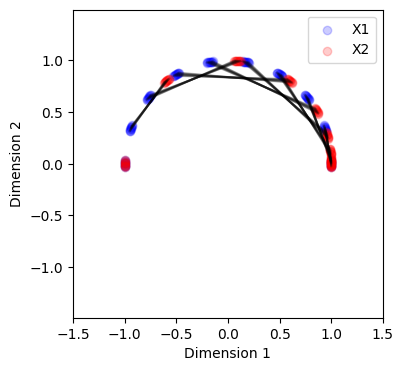

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.2, c='b', label='X1')
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.2, c='r', label='X2')
for i in range(X1.shape[0]):
    plt.plot([X1[i, 0], X2[i, 0]], [X1[i, 1], X2[i, 1]], color='black', alpha=0.2)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.axis('equal')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.show()

In [21]:
def create_focus_blob(n_points, min_theta1, max_theta1, min_theta2, max_theta2):
    t1 = np.linspace(min_theta1, max_theta1, n_points)
    t2 = np.linspace(min_theta2, max_theta2, n_points)
    X1 = np.vstack([np.cos(t1), np.sin(t1)]).T
    X2 = np.vstack([np.cos(t2), np.sin(t2)]).T
    return X1, X2

X1a, X2a = create_focus_blob(100, np.pi/2, np.pi, 0, np.pi/8)
X1b, X2b = create_focus_blob(10, 1.5*np.pi, 1.6*np.pi, np.pi, 2*np.pi)
X1 = np.vstack([X1a, X1b])
X2 = np.vstack([X2a, X2b])


X1 *= np.array([1, 10])
X2 *= np.array([1, 10])

# noise = np.random.normal(0, 0.01, X1.shape)
# X1 += noise
# X2 += noise

cka_similarity = gs.cka(X1, X2)
gs_similarity = gs.mean_neighborhood_similarity_from_points(X1, X2, k=5)
print(cka_similarity, gs_similarity)

0.24424804124965266 0.6493506493506486


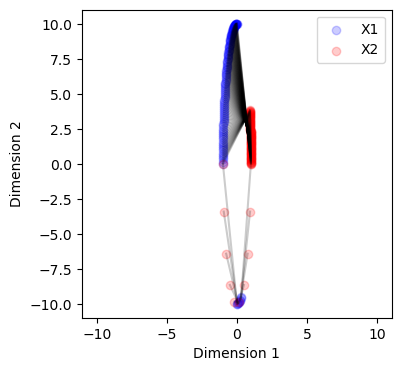

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.2, c='b', label='X1')
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.2, c='r', label='X2')
for i in range(X1.shape[0]):
    plt.plot([X1[i, 0], X2[i, 0]], [X1[i, 1], X2[i, 1]], color='black', alpha=0.2)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.axis('equal')

plt.show()